In [1]:
%matplotlib inline

import numpy as np 
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['font.family'] = 'stixgeneral'

In [2]:
use1sig = False # data table written in 1sig upper limit, but in analysis we use 3sig 
ecolor = plt.cm.Greys(0.6)
color = plt.cm.Greys(0.8)
fs = 16 
al = 1

ions = ['HI', 'CII', 'CIV', 'SiII', 'SiIII', 'SiIV']

In [3]:
from load_cgm_dwarf_mod import init_logN_rho_plot_6panel # create a figure with observational data points 
from load_cgm_dwarf_mod import get_percentile # get the 16th, 50th, and 84th percentile 
from load_cgm_dwarf_mod import plot_posterior # randomly draws n sample from posterior distribution and plot 
from load_cgm_dwarf_mod import linear_model # power law in log log space
from load_cgm_dwarf_mod import read_ion_measurements_logN 
from load_cgm_dwarf_mod import plot_obsdata

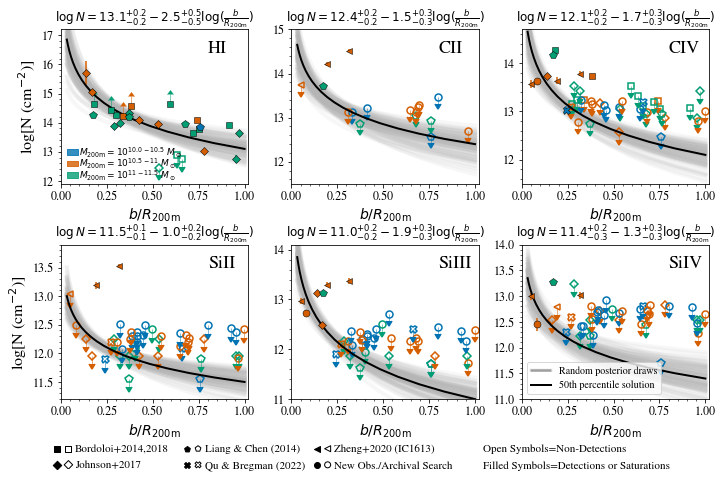

In [4]:
fig, axes, ylims = init_logN_rho_plot_6panel(fs=fs)
k_results = np.zeros((len(ions), 3)) # slope  value, e_neg, e_pos
logN0_results = np.zeros((len(ions), 3)) # intercept value, e_neg, e_pos

for j in range(len(ions)): 
    ion = ions[j]
    ax = axes[j]
    
    ### add data 
    ax, file_label = plot_obsdata(ax, ion, use1sig=use1sig, ecolor=ecolor, 
                                  color=color, fs=fs, al=al, 
                                  add_legend_byhand=True)
        
    ## add posterior 
    logN_labels = [r'$\alpha_N$', r'$\log N_0$']
    logN_chainfile = './data/pymc3/pymc3_{}_chain_logN_{}.feather'.format(ion, file_label)
    logN_p50 = get_percentile(logN_chainfile, labels=logN_labels)
    logN_p50 = np.around(logN_p50, decimals=1)
    plot_posterior(ax, logN_chainfile, logN_p50, linear_model, nlines=100, 
                   al=0.1, c=plt.cm.Greys(0.4), zorder=1)
    
    # put the coefficient on top and save the results 
    k_results[j, :] = logN_p50[:, 0] 
    logN0_results[j, :] = logN_p50[:, 1]
    a1 = logN_p50[0, 1]
    b1 = logN_p50[2, 1]
    c1 = logN_p50[1, 1]
    d1 = logN_p50[0, 0] 
    e1 = logN_p50[2, 0] 
    f1 = logN_p50[1, 0] 
    txt1 = r'$\log N=%.1f^{+%.1f}_{%.1f}%.1f^{+%.1f}_{%.1f}\log(\frac{b}{R_{\rm 200m}})$'%(a1, b1, c1, d1, e1, f1)
    ax.set_title(txt1, fontsize=12)
    
    ## add legend
    #ytext = np.zeros(len(ions))
    #for k in range(len(ylims[ion][file_label])): 
    ytext = ylims[ion][file_label][1] - 0.15*(ylims[ion][file_label][1] - ylims[ion][file_label][0])
    ax.text(0.8, ytext, ion, fontsize=fs+2)
    ax.set_xlabel(r'$b/R_{\rm 200m}$', fontsize=fs-2)
    ax.set_ylim(ylims[ion][file_label][0], ylims[ion][file_label][1])

ax6 = axes[5]
ax6.legend(loc='lower left')
ax6.hlines(11.57, 0.043, 0.16, color=plt.cm.Greys(0.5), alpha=0.9, lw=2.5, zorder=10)


fig.savefig('figs/fig4_pymc3_logN_allions_{}.pdf'.format(file_label))

In [8]:
from astropy.table import Table, Column
tb = Table()
tb['ion'] = ions
tb['logN0'] = logN0_results[:, 0]
tb['logN0_e-'] = logN0_results[:, 1]
tb['logN0_e+'] = logN0_results[:, 2]
tb['k'] = k_results[:, 0]
tb['k_e-'] = k_results[:, 1]
tb['k_e+'] = k_results[:, 2]
tb

ion,logN0,logN0_e-,logN0_e+,k,k_e-,k_e+
str5,float64,float64,float64,float64,float64,float64
HI,13.1,-0.2,0.2,-2.5,-0.5,0.5
CII,12.4,-0.2,0.2,-1.5,-0.3,0.3
CIV,12.1,-0.2,0.2,-1.7,-0.3,0.3
SiII,11.5,-0.1,0.1,-1.0,-0.2,0.2
SiIII,11.0,-0.2,0.2,-1.9,-0.3,0.3
SiIV,11.4,-0.3,0.2,-1.3,-0.3,0.3


In [9]:
from astropy.io import ascii
ascii.write(tb, 'data/fig4_pymc3_logN0_k_fits.txt', format='csv', overwrite=True)